<a href="https://colab.research.google.com/github/s20488/PJN/blob/main/Copy_of_Fine_tuning_Modeli_Wizyjno_Je%CC%A8zykowych_(VLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Modeli Wizyjno-Językowych (VLM)

## Wstęp

Celem laboratorium jest zapoznanie się z procesem fine-tuningu modeli wizyjno-językowych (VLM) na przykładzie analizy zdjęć radiologicznych.

Trzeba:
* Przygotowywać dane do fine-tuningu VLM
* Skonfigurować model do efektywnego treningu przy użyciu techniki LoRA
* Przeprowadzać proces fine-tuningu
* Wykonywać inferencję na dostrojonym modelu
* Zapisać model

## Instalacja biblitek

Do wydajnego treningu będziemy używać bibliteki unsloth

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

## Inicjalizacja modelu

In [ ]:
from unsloth import FastVisionModel
import torch

# TODO: Uzupełnij kod inicjalizacji modelu z następującymi parametrami:
# - nazwa modelu: "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
# - kwantyzacja 4-bitowa
# - gradient checkpointing włączony

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.8: Fast Qwen2_Vl vision patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.36G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## Załadowanie adaptera lora

In [ ]:
# TODO: Uzupełnij kod konfiguracji LoRA z następującymi parametrami:
# - r=16
# - lora_alpha=16
# - finetune zarówno warstw wizyjnych jak i językowych
# - finetune zarówno modułów attention jak i MLP

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16,
    lora_alpha = 16,
)

## Przygowanie danych

Załaduj zbiór danych https://huggingface.co/datasets/lion-ai/UMIE-Visual-QA - podzbiór kits23

In [ ]:
from datasets import load_dataset

dataset = load_dataset("lion-ai/UMIE-Visual-QA", "kits23", split="train") #TODO

README.md:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/489 [00:00<?, ? examples/s]

Dataset powinien wyglądać tak

In [ ]:
dataset

Dataset({
    features: ['image', 'dataset_name', 'dataset_uid', 'phase_name', 'comparative', 'study_id', 'umie_id', 'mask', 'labels', 'report', 'visualized_image', 'qa'],
    num_rows: 489
})

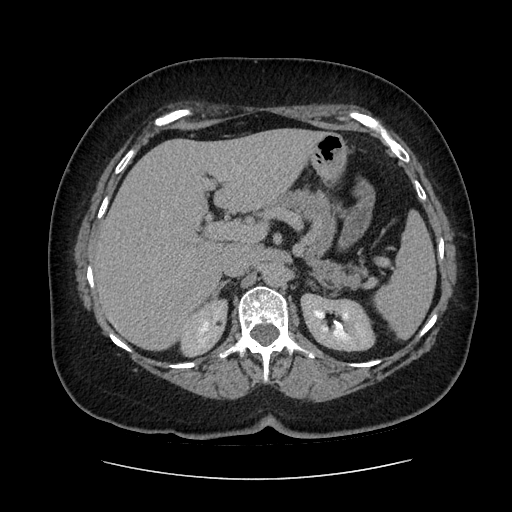

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["report"]

'The imaging study displays a standard axial view of the abdomen, primarily focusing on the renal region. Both kidneys are visible, with significant details observed. The left kidney appears normal in contour and density, without any discernible masses or cystic structures. In contrast, the right kidney displays an abnormality, characterized by a potential neoplasm that presents as a well-circumscribed lesion, indicating possible malignancy. Additionally, a renal cyst is noted adjacent to the right kidney, appearing as a fluid-filled area that is typically anechoic in nature, suggesting a benign process. There is no evidence of hydronephrosis or significant perinephric fat stranding. The surrounding structures, including the liver and spleen, are unremarkable, with no apparent lesions or abnormalities. The adjacent vascular structures appear intact, and there is no evidence of lymphadenopathy. Overall, the findings are consistent with a need for further evaluation of the right renal ma

## Formatowanie datasetu
Aby dotrenować model zbiór danych powinien być w takim formacie:
```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```



In [ ]:
#TODO: napisz funkcje konwerującą zbiór danych

instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["report"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Mapowanie datasetu

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

Dataset powinien wyglądac tak

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The imaging study displays a standard axial view of the abdomen, primarily focusing on the renal region. Both kidneys are visible, with significant details observed. The left kidney appears normal in contour and density, without any discernible masses or cystic structures. In contrast, the right kidney displays an abnormality, characterized by a potential neoplasm that presents as a well-circumscribed lesion, indicating possible malignancy. Additionally, a renal cyst is noted adjacent to the right kidney, appearing as a fluid-filled area that is typically anechoic in nature, suggesting a benign process. There is no evidence of hydronephrosis or significant perin

## Test bazowego modelu

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This image appears to be a cross-sectional view of the abdomen obtained from a computed tomography (CT) scan. Here are the key features observed:

1. **Liver**: The liver is visible on the left side of the image, with a homogeneous texture and no obvious abnormalities such as masses or lesions.

2. **Spleen**: The spleen is visible on the right side of the image, also showing a homogeneous texture with no apparent abnormalities.

3. **Kidneys**: The kidneys are visible on both sides of the image, with the right kidney slightly more anterior than the left. The renal cortices and medullae are


## Trening modelu

In [ ]:
#TODO: stwórz obiekt trainer, przekaż do niego model, tokenizer i dataset, użyj odpowiedniego collatora danych

In [ ]:
from trl import SFTTrainer, SFTConfig
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=converted_dataset,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    args=SFTConfig(
        output_dir = "outputs",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",

        # Ważne - parametry do vision fine-tuningu
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.713 GB of memory reserved.


Trening powinien zając ok 10 min

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 489 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,2.046300
2,2.158500
3,2.079100
4,1.932800
5,1.828300
6,1.745400
7,1.591200
8,1.425800
9,1.402200
10,1.279200


## Testy wytrenowanego modelu

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The imaging reveals a cross-sectional view of the abdominal region, prominently displaying the kidneys. The left kidney appears normal in size and shape, with no significant abnormalities noted. The right kidney, however, exhibits a notable lesion, characterized by a well-defined, irregular shape, suggestive of a neoplasm. This lesion is located adjacent to the renal parenchyma, indicating potential involvement or proximity to the renal capsule. Additionally, there is a renal cyst visible, which appears as a rounded structure with thin walls, consistent with a simple cyst. The surrounding renal tissue appears unremarkable, with no evidence of hydronephrosis or significant ed


## Zapisywanie modeli
Uwaga - to zapisuje tylko adapter nie cały model, jakbyśmy chcieli zapisać cały model trzeba go zmergować

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]